# Variational AutoEncoders

Full Name: Mohammad Morsali

Student ID: 400101956


# Variational Autoencoder

In this notebook, you will implement a variational autoencoder and a conditional variational autoencoder with slightly different architectures and apply them to the popular MNIST handwritten dataset.

Load several useful packages that are used in this notebook:

In [2]:
import math
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn import init
import torchvision
import torchvision.transforms as T
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.utils.data import sampler
import torchvision.datasets as datasets
import random
import cv2
import matplotlib as mpl
import numpy as np
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
%matplotlib inline
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# for plotting
plt.rcParams['figure.figsize'] = (10.0, 8.0)
plt.rcParams['font.size'] = 16
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

We will use GPUs to accelerate our computation in this notebook. Run the following to make sure GPUs are enabled:

In [3]:
if torch.cuda.is_available():
    print('Good to go!')
else:
    print('Please set GPU via Edit -> Notebook Settings.')

Good to go!


## Load MNIST Dataset


VAEs are notoriously finicky with hyperparameters, and also require many training epochs. In order to make this assignment approachable, we will be working on the MNIST dataset, which has 60,000 training and 10,000 test images. Each picture contains a centered image of white digit on black background (0 through 9). This was one of the first datasets used to train convolutional neural networks and it is fairly easy -- a standard CNN model can easily exceed 99% accuracy.

To simplify our code here, we will use the PyTorch MNIST wrapper, which downloads and loads the MNIST dataset.

In [4]:
batch_size = 128

mnist_train = datasets.MNIST('./MNIST_data', train=True, download=True,
                           transform=T.ToTensor())
loader_train = DataLoader(mnist_train, batch_size=batch_size,
                          shuffle=True, drop_last=True, num_workers=2)


Failed to download (trying next):
<urlopen error [Errno 111] Connection refused>



100%|██████████| 9.91M/9.91M [00:00<00:00, 11.5MB/s]


Extracting ./MNIST_data/MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST_data/MNIST/raw

Failed to download (trying next):
<urlopen error [Errno 111] Connection refused>



100%|██████████| 28.9k/28.9k [00:00<00:00, 342kB/s]


Extracting ./MNIST_data/MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST_data/MNIST/raw

Failed to download (trying next):
<urlopen error [Errno 111] Connection refused>



100%|██████████| 1.65M/1.65M [00:00<00:00, 3.23MB/s]


Extracting ./MNIST_data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST_data/MNIST/raw

Failed to download (trying next):
<urlopen error [Errno 111] Connection refused>



100%|██████████| 4.54k/4.54k [00:00<00:00, 6.96MB/s]

Extracting ./MNIST_data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST_data/MNIST/raw



## Visualize dataset

It is always a good idea to look at examples from the dataset before working with it. Let's visualize the digits in the MNIST dataset. We have defined the function `show_images` to visualize the images.


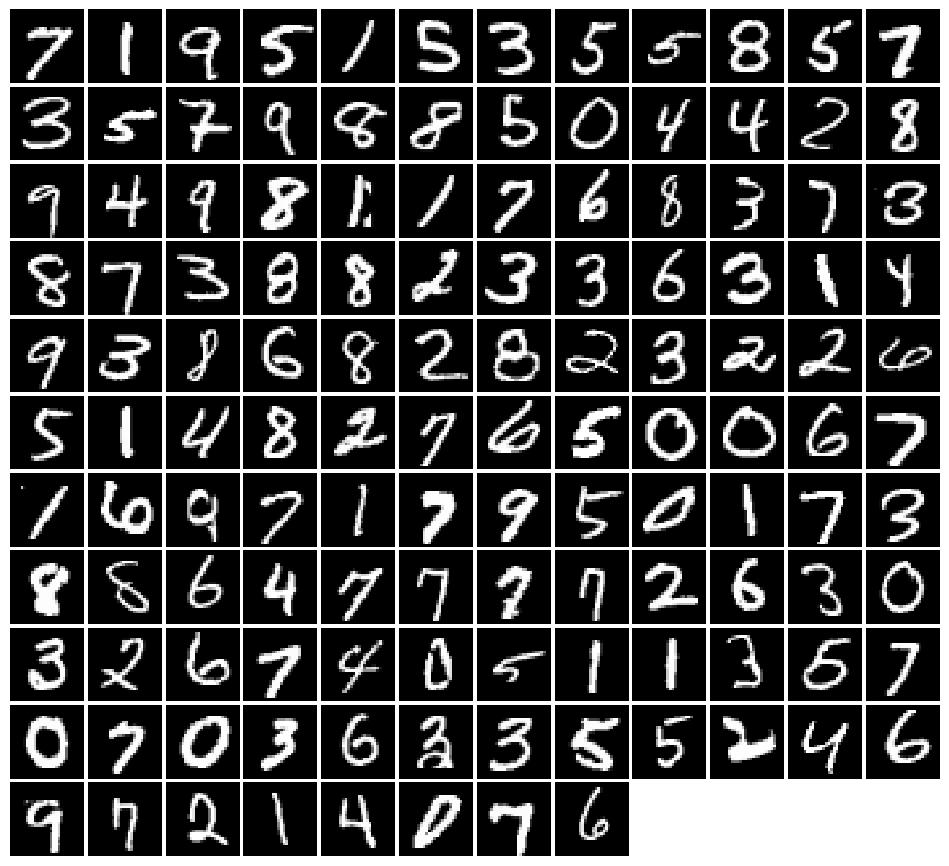

In [5]:
def show_images(images):
    images = torch.reshape(
        images, [images.shape[0], -1]
    )
    sqrtn = int(math.ceil(math.sqrt(images.shape[0])))
    sqrtimg = int(math.ceil(math.sqrt(images.shape[1])))

    fig = plt.figure(figsize=(sqrtn, sqrtn))
    gs = gridspec.GridSpec(sqrtn, sqrtn)
    gs.update(wspace=0.05, hspace=0.05)

    for i, img in enumerate(images):
        ax = plt.subplot(gs[i])
        plt.axis("off")
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        ax.set_aspect("equal")
        plt.imshow(img.reshape([sqrtimg, sqrtimg]))
    return

data_iter = iter(loader_train)
imgs, _ = next(data_iter)
imgs = imgs.view(batch_size, 784)
show_images(imgs)

# Fully Connected VAE

Your first VAE implementation will consist solely of fully connected layers. You'll take the `1 x 28 x 28` shape of our input and flatten the features to create an input dimension size of 784. In this section you'll define the Encoder and Decoder models in the VAE class and implement the reparametrization trick, forward pass, and loss function to train your first VAE.

## FC-VAE Forward

Complete the VAE class by writing the initialization and the forward pass. The forward pass should pass the input image through the encoder to calculate the estimation of mu and logvar, reparametrize to estimate the latent space z, and finally pass z into the decoder to generate an image.



In [6]:
class VAE_MLP(nn.Module):
    def __init__(self, input_dim, hidden_dim, latent_dim, device):
        super(VAE_MLP, self).__init__()
        # TODO: Define the architecture of the encoder and decoder
        
        # Encoder: we add two fully-connected layers with ReLU + optional BatchNorm for stability
        self.encoder = nn.Sequential(
            # TODO: Add layers for the encoder
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.BatchNorm1d(hidden_dim), 
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
        )

        # Two separate fully-connected layers for μ and log(σ^2)
        self.fc_mu = nn.Linear(hidden_dim, latent_dim)     
        self.fc_logvar = nn.Linear(hidden_dim, latent_dim) 

        # Decoder: symmetric MLP layers with ReLU + optional BatchNorm
        self.decoder = nn.Sequential(
            # TODO: Add layers for the decoder
            nn.Linear(latent_dim, hidden_dim),
            nn.ReLU(),
            nn.BatchNorm1d(hidden_dim), 
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, input_dim),
            nn.Sigmoid(),  # Sigmoid for output in [0, 1], suitable for image pixel reconstruction
        )

        # Store device to place tensors
        self.device = device

    def reparameterize(self, mu, logvar):
        # TODO: Implement the reparameterization trick
        # std = exp(0.5 * logvar), sample epsilon ~ N(0, 1), then z = mu + epsilon * std
        std_dev = torch.exp(0.5 * logvar)
        epsilon = torch.randn_like(std_dev).to(self.device)
        z = mu + epsilon * std_dev
        return z

    def forward(self, x):
        # TODO: Implement the forward pass
        
        # Flatten input and move to device
        x = x.view(x.size(0), -1).to(self.device)
        
        # Encode input
        encoded_data = self.encoder(x)
        
        # Obtain parameters for the latent distribution
        mean_val = self.fc_mu(encoded_data)
        log_variance = self.fc_logvar(encoded_data)
        
        # Sample from the latent space via reparameterization
        latent_sample = self.reparameterize(mean_val, log_variance)
        
        # Decode to reconstruct
        reconstruction = self.decoder(latent_sample)
        
        # Return reconstruction and the distribution parameters
        return reconstruction, mean_val, log_variance


## Loss Function

Complete the vae_loss function below

In [7]:
def vae_loss(recon, data, mu, logvar):
    # TODO: Implement the reconstruction loss
    # Flatten data to match the shape of recon (batch_size, input_dim)
    data_flattened = data.view(data.size(0), -1)
    # We use binary cross-entropy for reconstruction
    reconstruction_error = F.binary_cross_entropy(recon, data_flattened, reduction='sum')

    # TODO: Implement the KL divergence loss
    kl_divergence = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())

    # TODO: Return the total loss as the sum of reconstruction and KL divergence losses
    total_loss = reconstruction_error + kl_divergence
    return total_loss



## Train a model

Now that we have our VAE defined and loss function ready, lets train our model!

Complete the train_vae_mlp function to train the network.

In [8]:
def train_vae_mlp(model, train_loader, num_epochs=30, learning_rate=1e-3):
    model.train()  
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)  
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu') 
    model.to(device)

    for epoch in range(num_epochs):
        print()
        print(45 * "=")
        total_loss = []
        for batch_idx, (data, _) in enumerate(train_loader):
            # TODO: Forward process
        
            data = data.to(device)

            # Zero out gradients before backprop
            optimizer.zero_grad()

            # Model forward pass: returns reconstructed data + latent params
            recon, mu, logvar = model(data)

            # TODO: Flatten the data and recon tensors

            # data_flat = data.view(data.size(0), -1)
            # recon_flat = recon.view(recon.size(0), -1)

            # TODO: Calculate the loss using the vae_loss function

            loss = vae_loss(recon, data, mu, logvar) 

            # TODO: Backpropagation and optimization step
            loss.backward()
            optimizer.step()

            total_loss.append(loss.item())

        avg_loss = float(sum(total_loss) / len(total_loss))
        print(f'VAE- Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss}')  

# TODO: Train VAE
latent_size = 20  # Example assignment for latent_size
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

batch_size = 128
mnist_train = datasets.MNIST(
    root='./MNIST_data',
    train=True,
    download=True,
    transform=T.ToTensor()
)
loader_train = DataLoader(
    mnist_train,
    batch_size=batch_size,
    shuffle=True,
    drop_last=True,
    num_workers=2
)

VAE = VAE_MLP(
    input_dim=28 * 28,
    hidden_dim=512,
    latent_dim=latent_size,
    device=device
)

train_vae_mlp(VAE, loader_train)



VAE- Epoch [1/30], Loss: 17204.882476545805

VAE- Epoch [2/30], Loss: 14314.369843833467

VAE- Epoch [3/30], Loss: 13932.238247863248

VAE- Epoch [4/30], Loss: 13712.724676148504

VAE- Epoch [5/30], Loss: 13579.978256877672

VAE- Epoch [6/30], Loss: 13451.169967781785

VAE- Epoch [7/30], Loss: 13356.811250083467

VAE- Epoch [8/30], Loss: 13284.318887303018

VAE- Epoch [9/30], Loss: 13225.95633638822

VAE- Epoch [10/30], Loss: 13166.48499891493

VAE- Epoch [11/30], Loss: 13108.88957540398

VAE- Epoch [12/30], Loss: 13071.430405315172

VAE- Epoch [13/30], Loss: 13039.20154538929

VAE- Epoch [14/30], Loss: 12993.88372646234

VAE- Epoch [15/30], Loss: 12962.949007996127

VAE- Epoch [16/30], Loss: 12926.058670956865

VAE- Epoch [17/30], Loss: 12900.592022235576

VAE- Epoch [18/30], Loss: 12883.734537760416

VAE- Epoch [19/30], Loss: 12852.84004198384

VAE- Epoch [20/30], Loss: 12832.12003372062

VAE- Epoch [21/30], Loss: 12802.051108857506

VAE- Epoch [22/30], Loss: 12796.121734358307

VAE

## Visualize results

After training our VAE network, we're able to take advantage of its power to generate new training examples. This process simply involves the decoder: we intialize some random distribution for our latent spaces z, and generate new examples by passing these latent space into the decoder.

Run the cell below to generate new images! You should be able to visually recognize many of the digits, although some may be a bit blurry or badly formed. Our next model will see improvement in these results.

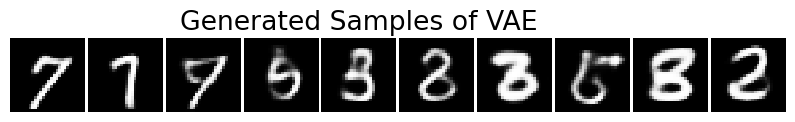

In [43]:
num_samples = 10
z = torch.randn(num_samples, latent_size).to(device=device)

VAE.eval()
samples = VAE.decoder(z).data.cpu().numpy()

fig = plt.figure(figsize=(num_samples, 1))
gspec = gridspec.GridSpec(1, num_samples)
gspec.update(wspace=0.05, hspace=0.05)
for i, sample in enumerate(samples):
    ax = plt.subplot(gspec[i])
    plt.axis('off')
    if i == 4:
      plt.title('Generated Samples of VAE')
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    ax.set_aspect('equal')
    plt.imshow(sample.reshape(28,28), cmap='Greys_r')

# Conditional FC-VAE

The second model you'll develop will be very similar to the FC-VAE, but with a slight conditional twist to it. We'll use what we know about the labels of each MNIST image, and *condition* our latent space and image generation on the specific class. Instead of $q_{\phi} (z|x)$ and $p_{\phi}(x|z)$ we have $q_{\phi} (z|x,c)$  and $p_{\phi}(x|z, c)$

This will allow us to do some powerful conditional generation at inference time. We can specifically choose to generate more 1s, 2s, 9s, etc. instead of simply generating new digits randomly.

## Define Network with class input

Your CVAE architecture should be the same as your FC-VAE architecture, except you'll now concatenate a one-hot label vector to both the x input (in our case, the flattened image dimensions) and the z latent space.

If the one-hot vector is called `c`, then `c[label] = 1` and `c = 0` elsewhere.

For the `CVAE_MLP` class use the same FC-VAE architecture implemented in the last network.


In [44]:
import torch
import torch.nn as nn
import torch.nn.functional as F


class CVAE_MLP(nn.Module):
    def __init__(self, input_dim, hidden_dim, latent_dim, num_classes, device):
        super(CVAE_MLP, self).__init__()
        # TODO: Define the architecture of the encoder
        
        self.encoder = nn.Sequential(
            # TODO: Add layers for the encoder
            nn.Linear(input_dim + num_classes, hidden_dim),
            nn.ReLU(),
            nn.BatchNorm1d(hidden_dim),   
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
        )

        self.fc_mu = nn.Linear(hidden_dim, latent_dim)     
        self.fc_logvar = nn.Linear(hidden_dim, latent_dim)  
        self.fc_class = nn.Linear(hidden_dim, num_classes)  

        # TODO: Define the architecture of the decoder
        self.decoder = nn.Sequential(
            # TODO: Add layers for the decoder
            nn.Linear(latent_dim + num_classes, hidden_dim),
            nn.ReLU(),
            nn.BatchNorm1d(hidden_dim),  
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, input_dim),
            nn.Sigmoid(),  # Output in [0, 1] for image pixel reconstruction
        )

        # Store the device for later use
        self.device = device

    def reparameterize(self, mu, logvar):
        # TODO: Implement the reparameterization trick
        # z = mu + sigma * epsilon, where sigma = exp(0.5*logvar) and epsilon ~ N(0, I)
        std_dev = torch.exp(0.5 * logvar)
        epsilon = torch.randn_like(std_dev).to(self.device)
        return mu + epsilon * std_dev

    def forward(self, x, y):
        # 1) Flatten and concat x, y
        x = x.view(x.size(0), -1)
        y = y.view(y.size(0), -1)
        xy_input = torch.cat([x, y], dim=1)
    
        # 2) Encode
        encoded_data = self.encoder(xy_input)
        mean_val = self.fc_mu(encoded_data)
        log_variance = self.fc_logvar(encoded_data)
    
        class_logits = self.fc_class(encoded_data)
    
        # 3) Reparameterize
        z_sample = self.reparameterize(mean_val, log_variance)
    
        # 4) Decode
        zy_input = torch.cat([z_sample, y], dim=1)
        reconstruction = self.decoder(zy_input)
    
        return reconstruction, mean_val, log_variance, class_logits



If you want to build helper functions, you can write the code in the below cell.

# Loss Function

Complete the cvae_loss function below

In [45]:

def cvae_loss(recon, data, mu, logvar, class_logits, labels):
    # TODO: Flatten the data tensor
    flattened_data = data.view(data.size(0), -1)

    # TODO: Implement the reconstruction loss
    # Using binary cross-entropy between recon and the flattened input
    reconstruction_loss = F.binary_cross_entropy(
        recon, 
        flattened_data, 
        reduction='sum'
    )

    # TODO: Implement the KL divergence loss
    # KL = -0.5 * sum(1 + logvar - mu^2 - exp(logvar))
    kl_divergence = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())

    # TODO: Implement the cross-entropy loss for class prediction
    # class_logits is of shape [batch_size, num_classes]
    classification_loss = F.cross_entropy(
        class_logits, 
        labels, 
        reduction='sum'
    )

    # TODO: Return the total loss as the sum of reconstruction,
    #       KL divergence, and cross-entropy losses
    total_loss = reconstruction_loss + kl_divergence + classification_loss
    return total_loss


## Train model

Using the same training script, let's now train our CVAE!



In [46]:

def train_cvae_mlp(model, train_loader, num_epochs=30, learning_rate=1e-3):
    model.train()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    
    model.to(device)
    
    for epoch in range(num_epochs):
        print()
        print(45 * "=")
        total_loss = []
        for batch_idx, (data, labels) in enumerate(train_loader):
            # One-hot encode the labels
            data = data.to(device)
            labels = labels.to(device)
            y_onehot = torch.zeros(labels.size(0), 10, device=device)
            y_onehot.scatter_(1, labels.view(-1, 1), 1)

            # TODO: Forward pass through the model and calculate the loss using cvae_loss
            # Assuming your CVAE forward returns: recon, mu, logvar, class_logits
            recon, mu, logvar, class_logits = model(data, y_onehot)
            loss = cvae_loss(recon, data, mu, logvar, class_logits, labels)  # Fill in your cvae_loss

            # TODO: Backpropagation and optimization step
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            total_loss.append(loss.item())

        avg_loss = float(sum(total_loss) / len(total_loss))
        print(f'CVAE-MLP Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss}')  # Preserving print statement

# TODO: Train CVAE
latent_size = 30
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Example MNIST dataset and DataLoader
batch_size = 128
mnist_train = datasets.MNIST('./MNIST_data', train=True, download=True, transform=T.ToTensor())
loader_train = DataLoader(mnist_train, batch_size=batch_size, shuffle=True, drop_last=True, num_workers=2)

# Example initialization and training of the CVAE
CVAE = CVAE_MLP(input_dim=28*28, hidden_dim=512, latent_dim=latent_size, num_classes=10, device=device)
train_cvae_mlp(CVAE, loader_train)



CVAE-MLP Epoch [1/30], Loss: 17392.62757703993

CVAE-MLP Epoch [2/30], Loss: 14138.000154413729

CVAE-MLP Epoch [3/30], Loss: 13646.540665064103

CVAE-MLP Epoch [4/30], Loss: 13363.295758630475

CVAE-MLP Epoch [5/30], Loss: 13177.165802784455

CVAE-MLP Epoch [6/30], Loss: 13036.728523971688

CVAE-MLP Epoch [7/30], Loss: 12929.059228098291

CVAE-MLP Epoch [8/30], Loss: 12839.101159772303

CVAE-MLP Epoch [9/30], Loss: 12748.691132895967

CVAE-MLP Epoch [10/30], Loss: 12689.839036207934

CVAE-MLP Epoch [11/30], Loss: 12626.318396935096

CVAE-MLP Epoch [12/30], Loss: 12579.10294387687

CVAE-MLP Epoch [13/30], Loss: 12521.180624415732

CVAE-MLP Epoch [14/30], Loss: 12486.58658228165

CVAE-MLP Epoch [15/30], Loss: 12445.111096504406

CVAE-MLP Epoch [16/30], Loss: 12414.345481937768

CVAE-MLP Epoch [17/30], Loss: 12377.26714201055

CVAE-MLP Epoch [18/30], Loss: 12350.955184545272

CVAE-MLP Epoch [19/30], Loss: 12314.95953525641

CVAE-MLP Epoch [20/30], Loss: 12293.381652310363

CVAE-MLP Epoc

## Visualize Results

You've trained your CVAE, now let's conditionally generate some new data! This time, we can specify the class we want to generate by adding our one hot matrix of class labels. We use `torch.eye` to create an identity matrix, which effectively gives us one label for each digit. When you run the cell below, you should get one example per digit. Each digit should be reasonably distinguishable (it is ok to run this cell a few times to save your best results).



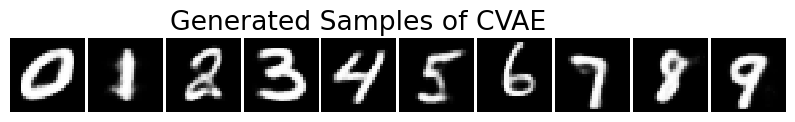

In [60]:
num_samples = 10
z = torch.randn(num_samples, latent_size)

c = torch.eye(num_samples, 10)

z = torch.cat((z,c), dim=-1).to(device='cuda')
CVAE.eval()
samples = CVAE.decoder(z).data.cpu().numpy()

fig = plt.figure(figsize=(num_samples, 1))
gspec = gridspec.GridSpec(1, num_samples)
gspec.update(wspace=0.05, hspace=0.05)
for i, sample in enumerate(samples):
    ax = plt.subplot(gspec[i])
    if i == 4:
      plt.title('Generated Samples of CVAE')
    plt.axis('off')
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    ax.set_aspect('equal')
    plt.imshow(sample.reshape(28, 28), cmap='Greys_r')